## Hospital & Order

### Hospital

In [1]:
# import package
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
import os
import math

In [4]:
hospital_data = pd.read_csv("inputs/hospitals.csv", header=None, names=["Hospital", "North", "East"])
print(hospital_data.head())

  Hospital  North   East
0  Bigogwe  50316 -39610
1   Butaro  74007   6631
2   Byumba  54174  30570
3   Gakoma -44557  15403
4  Gikonko -44743   8420


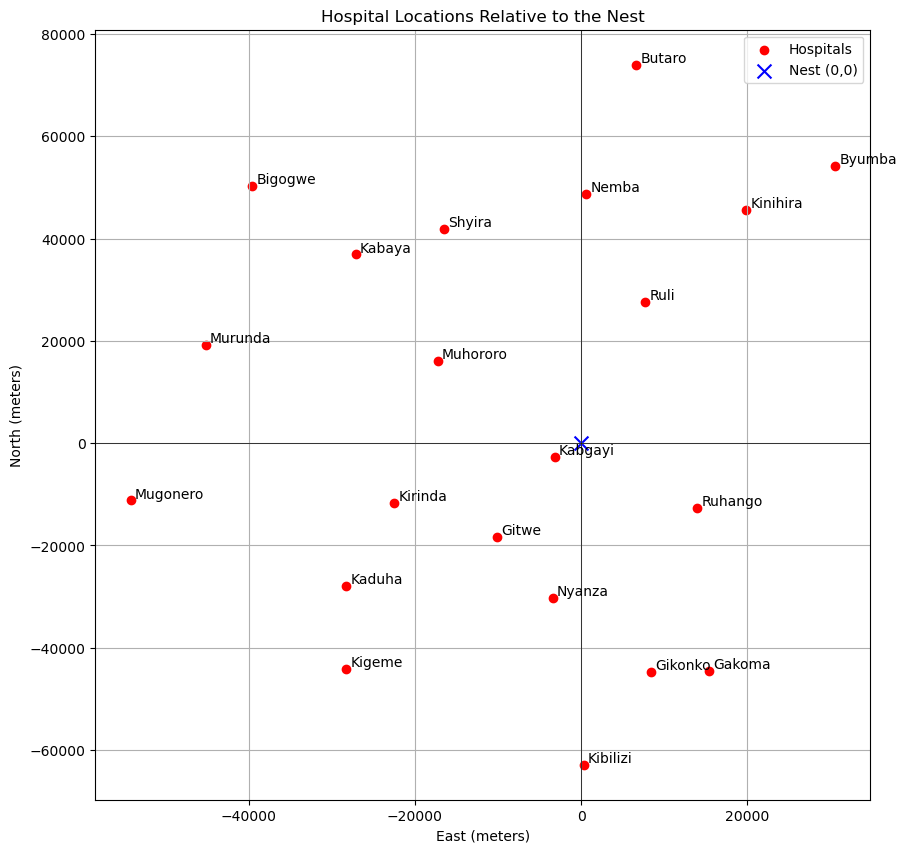

In [5]:
# plot all hospital locations
plt.figure(figsize=(10, 10))
plt.scatter(hospital_data['East'], hospital_data['North'], color='red', label='Hospitals')
plt.scatter(0, 0, color='blue', marker='x', s=100, label='Nest (0,0)')  # Nest (0,0)

for i, row in hospital_data.iterrows():
    plt.text(row['East'] + 500, row['North'] + 500, row['Hospital'], fontsize=10)

plt.axhline(0, color='black', linewidth=0.5)
plt.axvline(0, color='black', linewidth=0.5)
plt.xlabel("East (meters)")
plt.ylabel("North (meters)")
plt.title("Hospital Locations Relative to the Nest")
plt.legend()
plt.grid(True)

plt.show()

In [6]:
# coordinates of the Nest
nest_north = 0
nest_east = 0

# calculate Euclidean distance from each hospital to the Nest
hospital_data['Distance_to_Nest'] = np.sqrt((hospital_data['North'] - nest_north)**2 +
                                            (hospital_data['East'] - nest_east)**2)

print(hospital_data)

    Hospital  North   East  Distance_to_Nest
0    Bigogwe  50316 -39610      64036.333093
1     Butaro  74007   6631      74303.473741
2     Byumba  54174  30570      62204.076844
3     Gakoma -44557  15403      47144.232500
4    Gikonko -44743   8420      45528.369716
5      Gitwe -18412 -10076      20988.747461
6     Kabaya  36907 -27111      45794.464403
7    Kabgayi  -2684  -3192       4170.458008
8     Kaduha -28009 -28261      39789.297581
9   Kibilizi -62872    304      62872.734949
10    Kigeme -44124 -28249      52392.111782
11  Kinihira  45540  19857      49680.902256
12   Kirinda -11765 -22484      25376.080883
13  Mugonero -11198 -54232      55376.032975
14  Muhororo  15998 -17276      23545.619125
15   Murunda  19145 -45205      49091.985598
16     Nemba  48732    646      48736.281557
17    Nyanza -30251  -3422      30443.933468
18   Ruhango -12721  13960      18886.647161
19      Ruli  27664   7710      28718.304198
20    Shyira  41871 -16456      44988.671652


### Order

In [7]:
order_data = pd.read_csv("inputs/orders.csv", header=None, names=["Received Time", "Hospital Name", "Priority"])
print(order_data.head())

   Received Time Hospital Name    Priority
0          25634         Gitwe   Emergency
1          25803        Kaduha    Resupply
2          25892      Mugonero   Emergency
3          25967       Murunda    Resupply
4          26360        Gakoma    Resupply


In [8]:
# check the shape
order_data.shape

(300, 3)

## Traveling Zip

### Greedy Algorithm

In [9]:
# import package
import os
import math
import pandas as pd
from typing import Dict, List, TextIO, Tuple

In [10]:
# Each Nest has this many Zips
NUM_ZIPS = 10

# Each Zip can carry between 1 and this many packages per flight
# Note: a Zip can deliver more than 1 package per stop
MAX_PACKAGES_PER_ZIP = 3

# Zips fly a constant groundspeed (m/s)
ZIP_SPEED_MPS = 30

# Zips can fly a total roundtrip distance (m)
ZIP_MAX_CUMULATIVE_RANGE_M = 160 * 1000  # 160 km -> meters

# The two acceptable priorities
EMERGENCY = "Emergency"
RESUPPLY = "Resupply"

class Hospital:
    def __init__(self, name: str, north_m: int, east_m: int):
        self.name = name
        self.north_m = north_m
        self.east_m = east_m

    @staticmethod
    def load_from_csv(f: TextIO) -> Dict[str, "Hospital"]:
        hospitals = {}
        for line in f.readlines():
            fields = [values.strip() for values in line.split(",")]
            name = fields[0]
            hospitals[name] = Hospital(name=name, north_m=int(fields[1]), east_m=int(fields[2]))
        return hospitals

class Order:
    def __init__(self, order_id: int, time: int, hospital: Hospital, priority: str):
        self.order_id = order_id
        self.time = time
        self.hospital = hospital
        self.priority = priority

    @staticmethod
    def load_from_csv(f: TextIO, hospitals: Dict[str, Hospital]) -> List["Order"]:
        orders = []
        for i, line in enumerate(f.readlines()):
            fields = [values.strip() for values in line.split(",")]
            orders.append(Order(order_id=i+1, time=int(fields[0]), hospital=hospitals[fields[1]], priority=fields[2]))
        return orders

In [12]:
class Flight:
    def __init__(self, flight_id: int, zip_id: int, launch_time: int, orders: List[Order], route: List[str], completion_time: int, route_times: List[int]):
        """
        Args:
            flight_id : Unique ID for the flight.
            zip_id : The Zip performing the flight.
            launch_time : Time the flight launches.
            orders : List of orders delivered in this flight.
            route : List of locations the flight visits.
            completion_time: Time the flight completes its journey.
            route_times: List of segment times for the flight route.
        """
        self.flight_id = flight_id
        self.zip_id = zip_id
        self.launch_time = launch_time
        self.orders = orders
        self.route = route
        self.completion_time = completion_time
        self.route_times = route_times

    def __str__(self) -> str:
        return f"<Flight {self.flight_id} (Zip {self.zip_id}) @ {self.launch_time} Route: {' -> '.join(self.route)}>"



class ZipScheduler:
    def __init__(self, hospitals: Dict[str, Hospital]):
        self.hospitals = hospitals
        self._unfulfilled_orders: List[Order] = []
        self.zip_availability = {i: 0 for i in range(1, NUM_ZIPS + 1)}  # each Zip is available


    def calculate_segment_time(self, start_location: str, end_location: str) -> int:
        """
        Calculate the time for a Zip to travel between two locations.
        """
        start = Hospital("Nest", 0, 0) if start_location == "Nest" else self.hospitals[start_location]
        end = Hospital("Nest", 0, 0) if end_location == "Nest" else self.hospitals[end_location]

        distance = math.sqrt((end.north_m - start.north_m) ** 2 + (end.east_m - start.east_m) ** 2)
        return int(distance / ZIP_SPEED_MPS)


    def calculate_route_times(self, route: List[str]) -> List[int]:
        """
        Calculate flight time for each segment of the route.
        """
        return [self.calculate_segment_time(route[i], route[i + 1]) for i in range(len(route) - 1)]


    def get_available_zips(self, current_time: int) -> List[int]:
        """
        Get a list of Zip IDs that are available.
        """
        return [zip_id for zip_id, available_time in self.zip_availability.items() if current_time >= available_time]


    def queue_order(self, order: Order) -> None:
        """
        Add a new order to the unfulfilled order queue.
        """
        self._unfulfilled_orders.append(order)


    def launch_flights(self, current_time: int, flight_id_counter: int) -> Tuple[List[Flight], int]:
        """
        Assigns orders to available Zips and schedules flights.
        """
        flights = []
        if not self._unfulfilled_orders:
            return flights, flight_id_counter

        available_zips = self.get_available_zips(current_time)
        if not available_zips:
            return flights, flight_id_counter

        # sort orders: Emergency orders first, then by earliest time
        self._unfulfilled_orders.sort(key=lambda x: (x.priority != EMERGENCY, x.time))

        for zip_id in available_zips:
            if not self._unfulfilled_orders:
                break

            flight_orders = []
            route = ["Nest"]
            total_distance = 0
            last_location = (0, 0)  # start at Nest

            for order in list(self._unfulfilled_orders):
                if len(flight_orders) >= MAX_PACKAGES_PER_ZIP:
                    break  # stop adding orders when max capacity is reached

                hospital_location = (order.hospital.north_m, order.hospital.east_m)
                distance_to_hospital = math.sqrt(
                    (hospital_location[0] - last_location[0]) ** 2 +
                    (hospital_location[1] - last_location[1]) ** 2
                )
                return_distance = math.sqrt(
                    (hospital_location[0] - 0) ** 2 + (hospital_location[1] - 0) ** 2
                )

                if total_distance + distance_to_hospital + return_distance > ZIP_MAX_CUMULATIVE_RANGE_M:
                    break  # ensure the Zip does not exceed max cumulative flight range

                # add hospital to route
                route.append(order.hospital.name)
                flight_orders.append(order)
                total_distance += distance_to_hospital
                last_location = hospital_location

                self._unfulfilled_orders.remove(order)

            # return to Nest after last delivery
            if flight_orders:
                route.append("Nest")

                # calculate segment times
                route_times = self.calculate_route_times(route)
                total_flight_time = sum(route_times)
                completion_time = current_time + total_flight_time

                # mark Zip as unavailable until completion
                self.zip_availability[zip_id] = completion_time

                # store flight details
                flights.append(Flight(
                    flight_id=flight_id_counter,
                    zip_id=zip_id,
                    launch_time=current_time,
                    orders=flight_orders,
                    route=route,
                    completion_time=completion_time,
                    route_times=route_times
                ))
                flight_id_counter += 1

        return flights, flight_id_counter


class Runner:
    def __init__(self, hospitals_path: str, orders_path: str):
        with open(hospitals_path, "r") as f:
            self.hospitals = Hospital.load_from_csv(f)
        with open(orders_path, "r") as f:
            self.orders = Order.load_from_csv(f, self.hospitals)
        self.scheduler = ZipScheduler(hospitals=self.hospitals)
        self.flight_id_counter = 1
        self.flight_data = []

    def run(self) -> None:
        sec_per_day = 24 * 60 * 60
        for sec_since_midnight in range(self.orders[0].time, sec_per_day, 60):
            self.__queue_pending_orders(sec_since_midnight)
            flights, self.flight_id_counter = self.scheduler.launch_flights(sec_since_midnight, self.flight_id_counter)
            for flight in flights:
                for stop in range(len(flight.route) - 1):
                    self.flight_data.append([
                        flight.flight_id,
                        flight.zip_id,
                        flight.route[stop],
                        flight.route[stop + 1],
                        flight.launch_time
                    ])

    def __queue_pending_orders(self, sec_since_midnight: int) -> None:
        while self.orders and self.orders[0].time <= sec_since_midnight:
            self.scheduler.queue_order(self.orders.pop(0))

    def get_flight_dataframe(self) -> pd.DataFrame:
        return pd.DataFrame(self.flight_data, columns=["Flight ID", "Zip ID", "From", "To", "Launch Time"])



In [14]:
hospitals_path = 'inputs/hospitals.csv'
orders_path = 'inputs/orders.csv'

# run the simulation
runner = Runner(hospitals_path=hospitals_path, orders_path=orders_path)
runner.run()


df = runner.get_flight_dataframe()
print(df.head(20))

    Flight ID  Zip ID      From        To  Launch Time
0           1       1      Nest     Gitwe        25634
1           1       1     Gitwe      Nest        25634
2           2       2      Nest    Kaduha        25814
3           2       2    Kaduha      Nest        25814
4           3       3      Nest  Mugonero        25934
5           3       3  Mugonero      Nest        25934
6           4       4      Nest   Murunda        25994
7           4       4   Murunda      Nest        25994
8           5       5      Nest    Gakoma        26414
9           5       5    Gakoma      Nest        26414
10          6       6      Nest    Byumba        26594
11          6       6    Byumba      Nest        26594
12          7       7      Nest    Gakoma        26654
13          7       7    Gakoma      Nest        26654
14          8       8      Nest    Kigeme        26774
15          8       8    Kigeme      Nest        26774
16          9       9      Nest  Kibilizi        26834
17        

In [18]:
# save the reusults in 'outputs' 
output_folder = 'outputs'
os.makedirs(output_folder, exist_ok=True)

output_path = os.path.join(output_folder, 'flights_output.csv')
df.to_csv(output_path, index=False)

print(f"Saved to {output_path}")

DataFrame saved to outputs/flights_output.csv


### Viz the Path

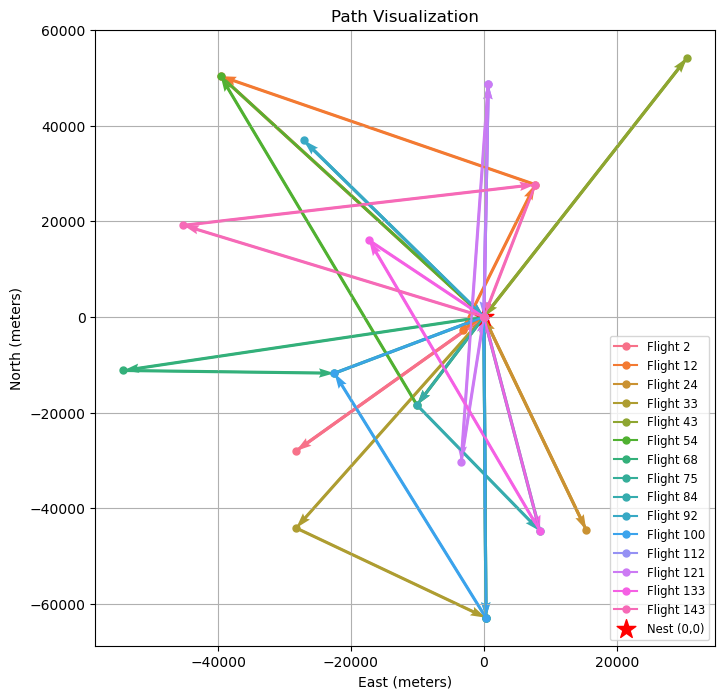

In [15]:
import matplotlib.pyplot as plt
import seaborn as sns

# select the Zip ID
zip_data = df[df["Zip ID"] == 2]

# get coordinates
coordinates = {"Nest": (0, 0)}  # Nest (0,0)
for index, row in hospital_data.iterrows():
    coordinates[row["Hospital"]] = (row["North"], row["East"])

unique_flight_ids = zip_data["Flight ID"].unique()
color_palette = sns.color_palette("husl", len(unique_flight_ids))
flight_colors = {flight_id: color_palette[i] for i, flight_id in enumerate(unique_flight_ids)}


plt.figure(figsize=(8, 8))

# plot each flight separately with diff color
for flight_id in unique_flight_ids:
    flight_data = zip_data[zip_data["Flight ID"] == flight_id]
    visited_locations = list(flight_data["From"]) + [flight_data["To"].iloc[-1]]

    x_coords = [coordinates[loc][1] for loc in visited_locations]
    y_coords = [coordinates[loc][0] for loc in visited_locations]

    flight_color = flight_colors[flight_id]

    plt.plot(x_coords, y_coords, marker='o', linestyle='-', color=flight_color, markersize=5, label=f"Flight {flight_id}")

    # add arrows for direction
    for i in range(len(x_coords) - 1):
        plt.quiver(
            x_coords[i], y_coords[i],
            x_coords[i+1] - x_coords[i], y_coords[i+1] - y_coords[i],
            angles='xy', scale_units='xy', scale=1, color=flight_color, width=0.005
        )

# the Nest location
plt.scatter(0, 0, color="red", marker="*", s=200, label="Nest (0,0)")

plt.xlabel("East (meters)")
plt.ylabel("North (meters)")
plt.title(f"Path Visualization")
plt.legend(fontsize='small')
plt.grid(True)

plt.show()


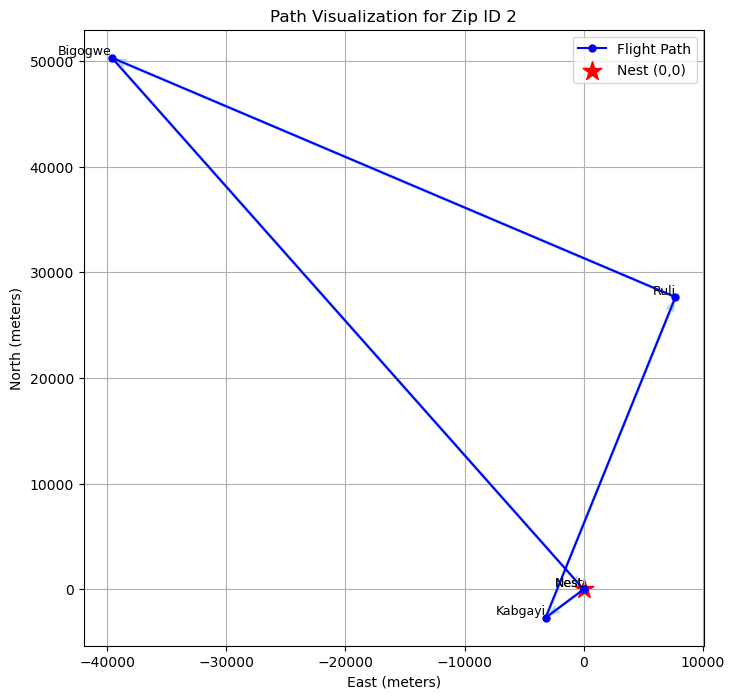

In [16]:
# filter only the rows for Flight ID 12
zip_2_data = df[df["Flight ID"] == 12]

visited_locations = list(zip_2_data["From"]) + [zip_2_data["To"].iloc[-1]]

# get coordinates for each visited location
coordinates = {"Nest": (0, 0)}  # Nest
for index, row in hospital_data.iterrows():
    coordinates[row["Hospital"]] = (row["North"], row["East"])

# extract coordinates
x_coords = [coordinates[loc][1] for loc in visited_locations]
y_coords = [coordinates[loc][0] for loc in visited_locations]

plt.figure(figsize=(8, 8))

# plot the flight path
plt.plot(x_coords, y_coords, marker='o', linestyle='-', color='blue', markersize=5, label="Flight Path")

# add arrows for direction
for i in range(len(x_coords) - 1):
    plt.quiver(
        x_coords[i], y_coords[i],
        x_coords[i+1] - x_coords[i], y_coords[i+1] - y_coords[i],
        angles='xy', scale_units='xy', scale=1, color='lightblue', width=0.005
    )

plt.scatter(0, 0, color="red", marker="*", s=200, label="Nest (0,0)")

# annotate points
for i, loc in enumerate(visited_locations):
    plt.text(x_coords[i], y_coords[i], loc, fontsize=9, verticalalignment='bottom', horizontalalignment='right')

plt.xlabel("East (meters)")
plt.ylabel("North (meters)")
plt.title(f"Path Visualization for Zip ID 2")
plt.legend()
plt.grid(True)

plt.show()


## Further Discussion

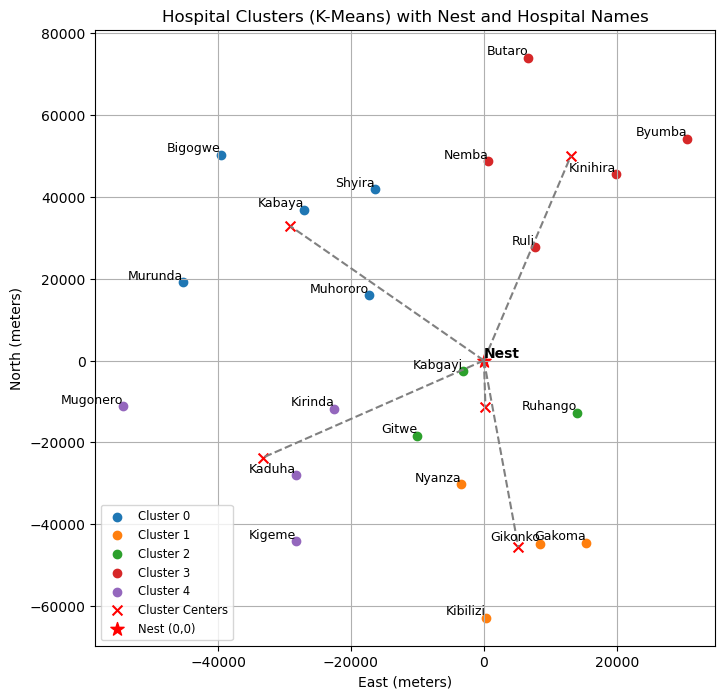

In [17]:
from sklearn.cluster import KMeans

X = hospital_data[["North", "East"]].values

# K-Means clustering
k = 5
kmeans = KMeans(n_clusters=k, random_state=909, n_init=10)
hospital_data["Cluster"] = kmeans.fit_predict(X)

# cluster centers
centers = kmeans.cluster_centers_

plt.figure(figsize=(8, 8))

# plot each cluster
for cluster in range(k):
    cluster_points = hospital_data[hospital_data["Cluster"] == cluster]
    plt.scatter(cluster_points["East"], cluster_points["North"], label=f"Cluster {cluster}")

    # each hospital with its name
    for _, row in cluster_points.iterrows():
        plt.text(row["East"], row["North"], row["Hospital"], fontsize=9, verticalalignment='bottom', horizontalalignment='right')

# mark cluster centers
plt.scatter(centers[:, 1], centers[:, 0], marker="x", color="red", s=50, label="Cluster Centers")

# add the Nest (0,0)
plt.scatter(0, 0, color="red", marker="*", s=100, label="Nest (0,0)")
plt.text(0, 0, "Nest", fontsize=10, fontweight="bold", verticalalignment='bottom', horizontalalignment='left')

# connect Nest to Cluster Centers
for center in centers:
    plt.plot([0, center[1]], [0, center[0]], color='gray', linestyle='--')

plt.xlabel("East (meters)")
plt.ylabel("North (meters)")
plt.title("Hospital Clusters (K-Means) with Nest and Hospital Names")
plt.legend(fontsize='small')
plt.grid(True)

plt.show()